## Baysian Linear Regression

- <i>Pattern Recognition and Machine Learning</i> by Bishop (2006)
    - [Section 3.3 -  Bayesian Linear Regression](#)   

In [1]:
# %load std_ipython_import.txt
import pandas as pd
import scipy as spy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pmc

pd.set_option('display.notebook_repr_html', False)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', 150)
#pd.set_option('display.max_seq_items', None)
#pd.set_option('expand_frame_repr', True)

%matplotlib inline
%config InlineBackend.figure_formats = {'retina',}
plt.style.use('seaborn-white')

### Generate data

- Consider single input variable $x$ and output variable $t$ and model: $y(x,\textbf{w}) = w_0 + w_1x$


- Select $x_n$ from the uniform distribution where $x_n$ between -1 and 1.


- Create data using the function:<BR>
$f(x,a) = a_0 + a_1x$<BR>
where<BR>
$a_0 = -0.3$ and $a_1 = 0.5$


- Add Gaussian noise with standard deviation 0.2 to obtain target values $t_n$.

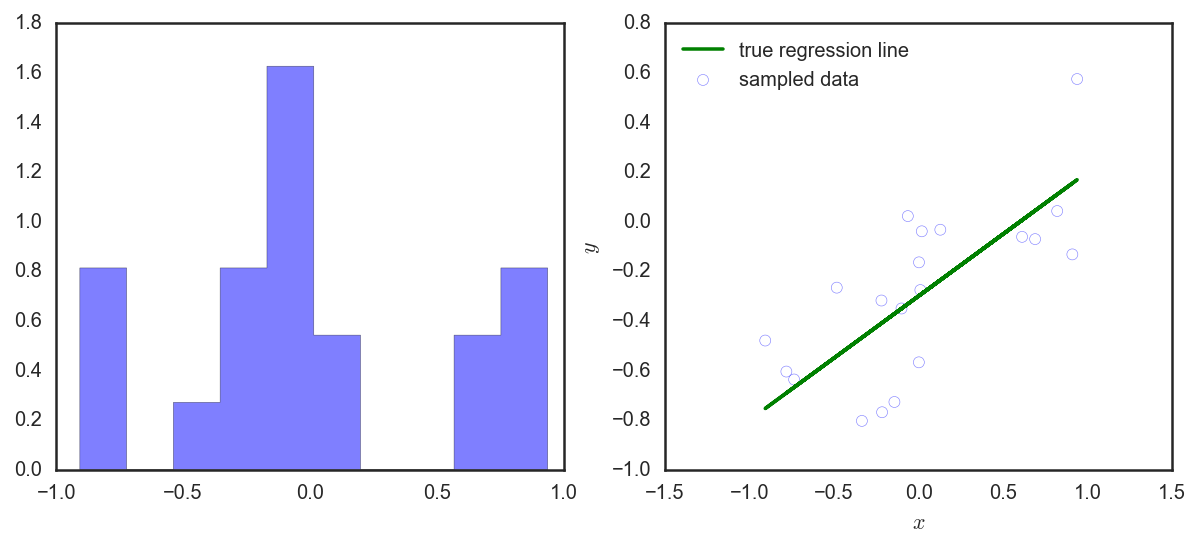

In [150]:
size = 20
a = [-0.3, 0.5]

x = spy.stats.uniform.rvs(-1, scale=2, size=size)
y_true = a[0] + a[1] * x 

sd = .2
t_n =  y_true + np.random.normal(scale=sd, size=size)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
ax1.hist(x, normed=True, histtype='stepfilled', alpha=0.5, color='b')
ax2.scatter(x, t_n, s=30, marker='o', alpha=0.5, facecolors='None', edgecolors='b', label='sampled data')
ax2.plot(x, y_true, c='g', label='true regression line')
ax2.set(xlabel='$x$', ylabel='$y$')
ax2.legend(loc=2);

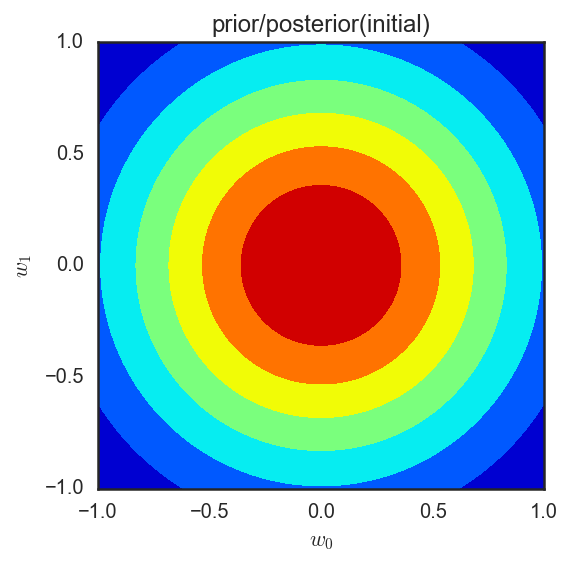

In [151]:
alpha = 2.
step = 100

rv = spy.stats.multivariate_normal(mean=[0,0], cov=alpha**-1*np.identity(2))

xx, yy = np.meshgrid(np.linspace(-1,1,step), np.linspace(-1,1,step))
Z = rv.pdf(np.c_[xx.ravel(),yy.ravel()])

plt.figure(figsize=(10,4))
plt.contourf(xx, yy, Z.reshape(step,step), cmap=plt.cm.jet)
plt.gca().set(title='prior/posterior(initial)', xlabel='$w_0$', ylabel='$w_1$', aspect='equal');

### MCMC sampling

In [152]:
data = pd.DataFrame({'x':x, 'y':t_n}).iloc[:,:]

with pmc.Model() as model:
    
    pmc.glm.glm('y ~ x', data)
    
    start = pmc.find_MAP()
    
    step = pmc.NUTS(scaling=start)

    trace = pmc.sample(1000, step, progressbar=True)

Applied log-transform to sd and added transformed sd_log to model.
 [-----------------100%-----------------] 1000 of 1000 complete in 0.7 sec

### Posterior probability distribution after sampling

/Users/jordi/anaconda/envs/probalistic/lib/python3.5/site-packages/pymc3-3.0-py3.5.egg/pymc3/tuning/scaling.py:159: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return x.reshape((x.shape[0], np.prod(x.shape[1:])))


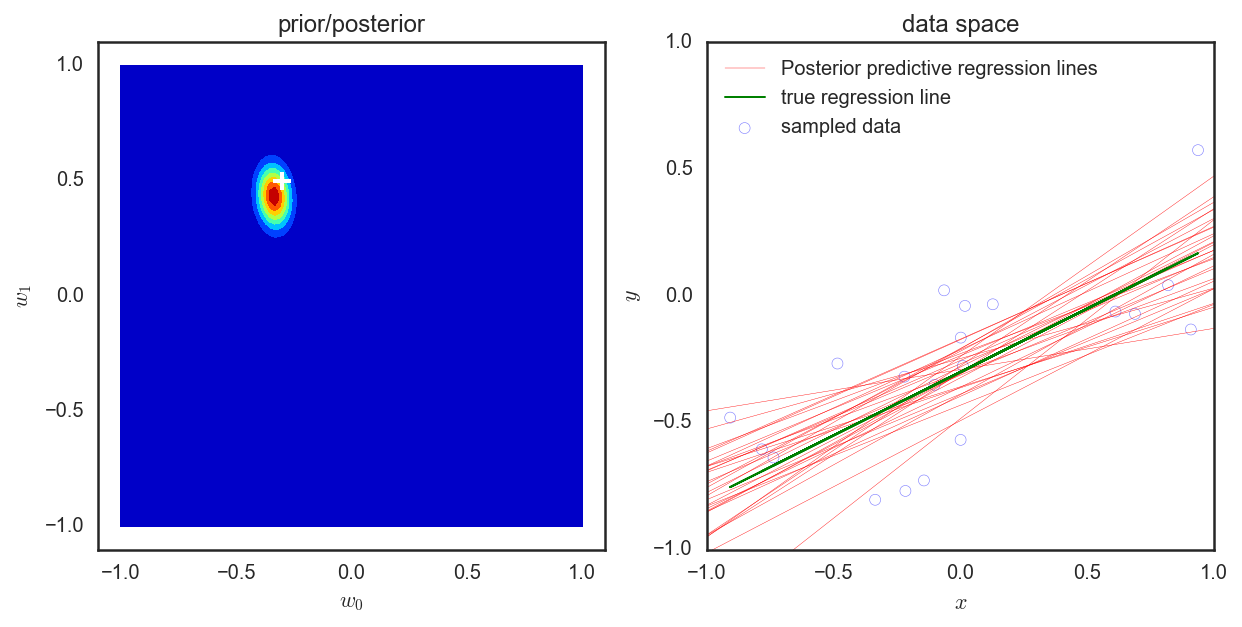

In [160]:
cov = pmc.trace_cov(trace, vars=['Intercept', 'x'])

alpha = 2.
step = 100

rv = spy.stats.multivariate_normal(mean=[trace.point(-1)['Intercept'], trace.point(-1)['x']], cov=alpha**-1*cov)

xx, yy = np.meshgrid(np.linspace(-1,1,step), np.linspace(-1,1,step))
Z = rv.pdf(np.c_[xx.ravel(),yy.ravel()])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,8))

# Left plot
ax1.contourf(xx, yy, Z.reshape(step,step), cmap=plt.cm.jet)
ax1.scatter(-.3, .5, s=80, c='w', marker='+', lw=2)
ax1.set(title='prior/posterior', xlabel='$w_0$', ylabel='$w_1$')

# Right plot
ax2.scatter(data.iloc[:,0], data.iloc[:,1], s=30, marker='o', alpha=0.5, facecolors='None', edgecolors='b',
            label='sampled data')
pmc.glm.plot_posterior_predictive(trace, samples=30, eval=np.asarray([-1,1]), alpha=1, c='r',
                                  label='Posterior predictive regression lines')
ax2.plot(x, y_true, c='g', label='true regression line', lw=1)
ax2.set(title='data space', xlabel='$x$', ylabel='$y$', xlim=(-1,1), ylim=(-1,1))
ax2.legend(loc=2)

for ax in fig.axes:
    ax.set_aspect('equal');